In [1]:
import torch
from torch.utils.data import Dataset
import os

#### Define the Dataset for Multi-digit-MNIST Images ####
<br>
We have to generate data in a train and test set. <br>
This can be done by the functions in "makeMultiDigits.ipynb" <br>
<br>
Or can we split data into train and test? <br>
Not sure, because we have (muliti-digit image, label, merge-coordinates) as "data-label" tripletts, not pairs. <br>
Of course (img, (lab, mc)) would be feasible.

In [2]:
class MultiDigitMNISTDataset(Dataset):
    def __init__(self, source_dir, img_transform=None, label_transform=None, merge_point_transform=None):
        self.source_dir = source_dir
        self.img_transform = img_transform
        self.label_transform = label_transform
        self.merge_point_transform = merge_point_transform
        
        self.data_record_entries = []
        cwd = os.getcwd()
        self.source_path = os.path.join(cwd, self.source_dir)
        with os.scandir(self.source_path) as it:
            for entry in it:
                if entry.is_file() and entry.name.endswith(".pt"):
                    self.data_record_entries.append(entry)
        
        self.data_records = []
    
    def __len__(self):
        return len(self.data_record_entries)
    
    def __getitem__(self, idx):
        data_record = torch.load(os.path.join(self.source_path, self.data_record_entries[idx].name))
        multi_img = data_record["multi_img"]
        multi_img_label = data_record["multi_img_label"]
        merge_points = data_record["merge_points"]
        if self.img_transform:
            multi_img = self.img_transform(multi_img)
        if self.label_transform:
            multi_img_label = self.label_transform(multi_img_label) 
        if self.merge_point_transform:
            merge_points = self.merge_point_transform(merge_points)
        
        return multi_img, multi_img_label, merge_points




### Build the Neural Net to learn finding the merge-points ###
<br>
At first we presume, that we know the number of merge-points and ask only for their x-coordinate
<br>
These coordinates will be used to split the image of the multi-digit number into single-digit numbers, <br>
leaving us with an standard MNIST-like problem for which there are good solutions available.


In [17]:
import torch.nn.functional as F

class MultiDigitMNISTNet(torch.nn.Module):

    def __init__(self, nof_digits):
        super(MultiDigitMNISTNet, self).__init__()
        # input MNIST images for nof_digits digit-image: 1 x nof_digitsx28 x nof_digitsx28
        self.numChannels1 = 8
        self.numChannels2 = 16
        self.numChannels3 = 32
        self.conv1 = torch.nn.Conv2d(1, self.numChannels1, 5, padding=2)
        # out: 8 x 28 x (nof_digits x 28)
        # max-pooling out: 8 x 14 x (nof_digits x 14)
        self.conv1_batchnorm = torch.nn.BatchNorm2d(num_features = self.numChannels1)
        self.conv2 = torch.nn.Conv2d(self.numChannels1, self.numChannels2, 3, padding=1)
        # out: 16 x 14 x (nof_digits x 14)
        self.conv2_batchnorm = torch.nn.BatchNorm2d(num_features = self.numChannels2)
        self.conv3 = torch.nn.Conv2d(self.numChannels2, self.numChannels3, 3)
        # out: (16 x ?: no!) 32 x (14 - 3 + 1) x (nof_digits x 14)- 3 + 1 
        # i.e.: out: 32 x 12 x (nof_digits x 14)- 2
        # max-pooling out: 32 x 6 x (nof_digits x 7)- 1
        # flatten out: 1 x 32 x 6 x (nof_digits x 7)- 1
        self.conv3_batchnorm = torch.nn.BatchNorm2d(num_features=self.numChannels3)
        self.fc1 = torch.nn.Linear(32 * 6 * ((nof_digits * 7)- 1), 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, nof_digits)
    
    def forward(self, x):
        x = self.conv1_batchnorm(self.conv1(x))
        x = F.max_pool2d(F.relu(x), (2,2))
        x = self.conv2_batchnorm(self.conv2(x))
        x = F.relu(x)
        x = self.conv3_batchnorm(self.conv3(x))
        x = F.max_pool2d(F.relu(x), (2,2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [18]:
# check of network: does it produce any output without Python error:

pseudo_img = torch.rand(2, 1, 28, 112)
print(pseudo_img.shape)

model = MultiDigitMNISTNet(nof_digits = 4)
model(pseudo_img)

torch.Size([2, 1, 28, 112])


tensor([[0.0033, 0.1858, 0.1694, 0.0000],
        [0.0000, 0.1293, 0.1472, 0.0000]], grad_fn=<ReluBackward0>)

In [25]:
import datetime

def training(epochs, train_loader, model, loss_fn, optimizer, device, show_progress= False):
    loss_train = 0.0
    model.train()
    for epoch in range(1, epochs + 1):
        for imgs, labs, mpoints in train_loader:
            imgs = imgs.to(device)
            mpoints = mpoints.to(device)
            
            y_mpoints = model(imgs)
            loss = loss_fn(y_mpoints, mpoints)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if(epoch == 1 or epoch%10 == 0):
            print(F"len train loader: {len(train_loader)}")
            print(f"{datetime.datetime.now()} Epoch {epoch} Training loss {loss_train/ len(train_loader)}")
            if(show_progress):
                print(model4.conv1.weight[0])


def validate(model, train_loader, val_loader, loss_fn):
    model.eval()
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        loss = 0
        for imgs, labs, mpoints in loader:
            with torch.no_grad():
                y_mpoints = model(imgs)
                print(y_mpoints)
                loss += loss_fn(y_mpoints, mpoints).item()
        
        print(f"Loss {name}: {loss/len(loader)}")



In [28]:
from torch.utils.data import DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device {device}")

BATCH_SIZE = 32
NOF_DIGITS = 2
TRAIN_DIR = "Mnist2_train"
VAL_DIR = "Mnist2_val"

TRAIN_DS = MultiDigitMNISTDataset(source_dir=TRAIN_DIR)
TRAIN_DL = DataLoader(TRAIN_DS, batch_size=BATCH_SIZE)

VAL_DS = MultiDigitMNISTDataset(source_dir=VAL_DIR)
VAL_DL = DataLoader(VAL_DS, batch_size=BATCH_SIZE)

# start with a new model each time:
model4 = None
model4 = MultiDigitMNISTNet(nof_digits= NOF_DIGITS).to(device=device)

# using weight_decay in SGD optimizer invoces L2 regularization
# #  - seems to be necessary since our wheigths and losses are extraordingly high:
optimizer = torch.optim.SGD(model4.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
loss_fn = torch.nn.MSELoss()

training(
    epochs = 100,
    train_loader = TRAIN_DL,
    model = model4,
    loss_fn = loss_fn,
    optimizer = optimizer,
    device = device,
    show_progress = True    
)

print("Training finished")


Using device cpu
len train loader: 29
2022-01-20 16:04:48.569228 Epoch 1 Training loss 13679.388831829203
tensor([[[ -67.1111,  -81.9827, -105.0017,  -69.4044, -332.0873],
         [ -14.9071,  -90.6512, -115.2830,  -12.3650,  -43.0841],
         [ 273.5671,  178.6299,   47.9097,  219.8836,  343.0193],
         [ 394.7130,  339.0486,  318.2964,  466.7368,  435.1472],
         [ 331.0794,  273.3391,  262.8351,  451.6009,  332.3095]]],
       grad_fn=<SelectBackward0>)
len train loader: 29
2022-01-20 16:05:07.272442 Epoch 10 Training loss 26119.951108735182
tensor([[[ -71.2303,  -87.0172, -111.4449,  -73.6591, -352.5064],
         [ -15.8156,  -96.2267, -122.3592,  -13.1203,  -45.7410],
         [ 290.3793,  189.6007,   50.8650,  233.4084,  364.1103],
         [ 418.9828,  359.8953,  337.8666,  495.4153,  461.9008],
         [ 351.4202,  290.1380,  278.9961,  479.3480,  352.7281]]],
       grad_fn=<SelectBackward0>)
len train loader: 29
2022-01-20 16:05:27.671538 Epoch 20 Training loss 3

In [29]:
validate(
    model = model4,
    train_loader = TRAIN_DL,
    val_loader = VAL_DL, 
    loss_fn = loss_fn
)


print("Validation finished.")

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [

In [36]:
# check the points, where the images are merged ("merge_points"), by drawing a grey vertical line:

from PIL import ImageDraw
import torchvision.transforms as TT
import matplotlib.pyplot as plt
import numpy as np

def display_merge_lines(image_record, model):
    t_img = image_record["multi_img"]
    y_mps = model(t_img.unsqueeze(0)).detach().numpy()
    img = TT.ToPILImage()(t_img)
    plt.title(mr["multi_img_label"])
    merge_points = mr["merge_points"]
    
    draw = ImageDraw.Draw(img)
    for ymp in [mp for mp in np.nditer(y_mps)]:
        draw.line([(ymp, 0), (ymp, 28)], width=1, fill= 128)
    plt.imshow(img, cmap="gray")

t_img.shape: torch.Size([1, 28, 56])


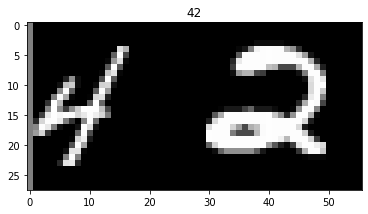

In [37]:
mr = torch.load("test2/42_26_51.pt")
#print(ir)
t_img = mr["multi_img"]
print(f"t_img.shape: {t_img.shape}")

display_merge_lines(mr, model4)

In [9]:
model4.conv1.weight[0]


tensor([[[-7.3786e+03, -3.6925e+03, -1.2801e+04, -3.1996e+04, -9.4015e+04],
         [-1.2355e+03, -1.5027e+03, -3.0971e+03, -2.3657e+04, -7.2421e+04],
         [-2.9844e+02, -8.2893e+02, -9.0846e+02, -1.2911e+04, -5.7599e+04],
         [-9.8314e+02, -6.7748e+01, -1.3130e+03, -1.3955e+04, -3.4848e+04],
         [-2.6726e+03, -4.3636e+02, -2.3244e+03, -1.4431e+04, -2.4138e+04]]],
       grad_fn=<SelectBackward0>)